In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import holoviews as hv
from holoviews import opts
import hvplot.xarray
import hvplot.networkx as hvnx

from pathlib import Path
from tqdm.notebook import tqdm

import networkx as nx
import geonetworkx as gnx

import warnings

warnings.filterwarnings('ignore')
hv.extension('bokeh')

## function to get stats

In [2]:
import scipy.stats as stats

def get_stats(obs, mod):
    corr, corr_p = stats.pearsonr(obs, mod)
    nse = 1 - (np.sum((obs - mod)**2)/np.sum((obs - np.mean(obs))**2))
    nse1 = 1 - (np.sum(np.abs(obs - mod))/np.sum(np.abs(obs - np.mean(obs))))
    rmse = np.sqrt(np.sum((obs-mod)**2)/len(mod))
    norm_rmse = rmse/(np.max(obs) - np.min(obs))
    mae = np.sum(np.abs(mod-obs))/len(mod)
    norm_mae = mae/(np.max(obs) - min(obs))
    kge = 1 - np.sqrt((corr-1)**2 +  (np.std(mod)/np.std(obs) - 1)**2 + (np.mean(mod)/np.mean(obs) - 1)**2) 

    # print({'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge})

    return {'pearson-r': corr, 'pearson-r p-val': corr_p, 'nse': nse, 'nse1': nse1, 'rmse': rmse, 'norm_rmse': norm_rmse, 'mae': mae, 'norm_mae': norm_mae, 'kge': kge}

## load modules

In [3]:
from reservoirnetwork.network import ReservoirNetwork

%load_ext autoreload
%autoreload 2

In [4]:
# quick and simple implementation without landlab
river_network_pts_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/cumberland_rivreg_usace/rivreg_pts.geojson')
river_network_fn = Path('/tiger1/pdas47/ResORR-revision/data-cumberland/cumberland_rivreg_usace/rivreg.geojson')

G = gnx.read_geofiles(river_network_pts_fn, river_network_fn, directed=True)
G

{0: Text(-0.4588325254462108, -0.8581231741887407, '0'),
 1: Text(0.3491585001694205, 1.0, '1'),
 2: Text(0.15952687933044393, 0.5331952235682094, '2'),
 3: Text(-0.3001801467079466, 0.43619539394129103, '3'),
 4: Text(-0.08536814202542983, -0.31623116159731185, '4'),
 5: Text(-0.02749569101949688, -0.8986134377967055, '5'),
 6: Text(0.3930432923543404, 0.03987328409375471, '6'),
 7: Text(-0.029852166655120815, 0.06370387197950354, '7')}

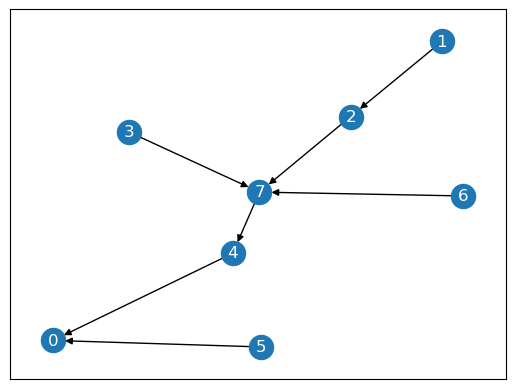

In [5]:
# plot reservoir network

pos = nx.drawing.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
# nx.draw_networkx_labels(G, pos, labels={node:G.nodes[node]['name'] for node in G.nodes},font_color='red')
nx.draw_networkx_labels(G, pos,font_color='white')

In [6]:
# aggregate
def aggregate(ds, frequency='weekly'):
    if frequency == 'daily':
        resampled = ds
        resampled['dt'] = ds['time'].resample(time='1D').count()
    elif frequency == 'weekly':
        resampled = ds.resample(time='1W').mean()
        resampled['dt'] = ds['time'].resample(time='1W').count()
    elif frequency == 'monthly':
        resampled = ds.resample(time='1M').mean()
        resampled['dt'] = ds['time'].resample(time='1M').count()
    elif frequency == 'annual':
        resampled = ds.resample(time='1Y').mean()
        resampled['dt'] = ds['time'].resample(time='1Y').count()
    else:
        raise ValueError(f'frequency {frequency} not supported')
    
    return resampled

def calculate_volumes(
        ds, 
        fluxes=['unregulated_inflow', 'obs_inflow', 'obs_outflow', 'obs_storage_change']
    ):
    """Calculate volume values using flow rates and ∆t

    Args:
        ds (xr.Dataset): Dataset containing flow rates in m3/day
    """
    for flux in fluxes:
        ds[flux] = ds[flux] * ds['dt']
        ds[flux].attrs['units'] = 'm3'
        ds[flux].attrs['long_name'] = f'Volume of {flux}'
        ds[flux].attrs['description'] = f'Volume of {flux} in m3'

    return ds

## create forcings

In [71]:
run_type = 'E4'
ds = xr.open_dataset(f'/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2015-2019.regulated.{run_type}.nc')

start_time = pd.to_datetime('2015-01-01')
end_time = pd.to_datetime('2019-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'daily'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        'storage_change': aggregated_subset['obs_storage_change'],
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow'],
        'dt': aggregated_subset['dt']
    }
).sel(time=slice(start_time, end_time))
forcings

<xarray.Dataset> Size: 472kB
Dimensions:                     (time: 1734, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

## add noise to forcings data

- We will take the example of the Cordell Hull Dam. It has 3 upstream dams, Laurel Dam, Wolf creek dam and Dale Hollow dam.
- Laurel Dam and Dale Hollow Dam are upstream most dams.
- We will add random noise to input data to the `obs_inflow` of (1) Laurel Dam [`node: 1`] and (2) Dale Hollow Dam [`node: 3`].

In [199]:
def add_scaled_gaussian_noise(data, noise_std_base, flow_scaling_factor):
    """
    Adds scaled Gaussian noise to a hydrograph data series.

    Args:
        data: A numpy array of hydrograph data.
        noise_std_base: Base standard deviation of the noise.
        flow_scaling_factor: Function that scales the noise std based on flow.

    Returns:
        A numpy array of the hydrograph data with scaled Gaussian noise added.
    """
    noise = np.random.normal(0, noise_std_base * flow_scaling_factor(data), size=data.shape)
    return np.clip(data - noise, a_min=0, a_max=None)  # Clip final data to non-negative values

# Example scaling function (example: noise decreases with lower flows)
def flow_scaling_factor(flow):
    # returns a scaling factor that can be multiplied with the base noise std deviation
    return (np.max(flow) - flow*2) / (np.max(flow) - np.min(flow))

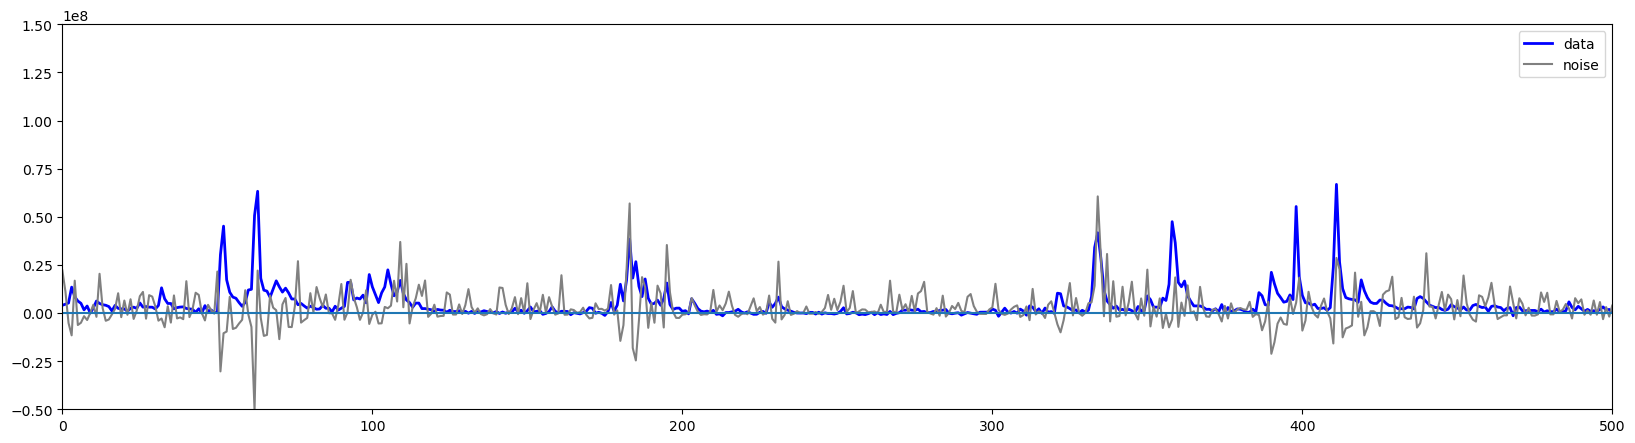

In [195]:
import matplotlib.pyplot as plt
# plt.plot(flow_scaling_factor(forcings['theoretical_natural_runoff'].sel(node=1).values))
plt.figure(figsize=(20, 5))

noise_std_base = 50e6
data = forcings['obs_inflow'].sel(node=3).fillna(0)

noisy_data = add_scaled_gaussian_noise(data, noise_std_base, flow_scaling_factor)
noise = noisy_data - data

# plt.plot(noise, label='noise')
plt.plot(data, label='data', color='blue', linewidth=2)
plt.plot(noise, label='noise', color='gray')
# plt.axhline(data.mean())
# plt.axhline(data.mean() + data.std(), linestyle='--')
# plt.plot(forcings['theoretical_natural_runoff'].sel(node=1), label='TNR', color='green')
# plt.plot(noisy_data, label='noisy data', color='red')
plt.legend()
plt.xlim(0, 500)
plt.ylim(-0.5e8, 1.5e8)
plt.axhline(0)

### another way of adding noise

* take the difference of observed and TNR
* add the scaled difference to the observed (say 0.5 times, 0.7 times, etc).
* at scaling of 0, data would be equal to observed, at scaling of 1, data would be equal to TNR.

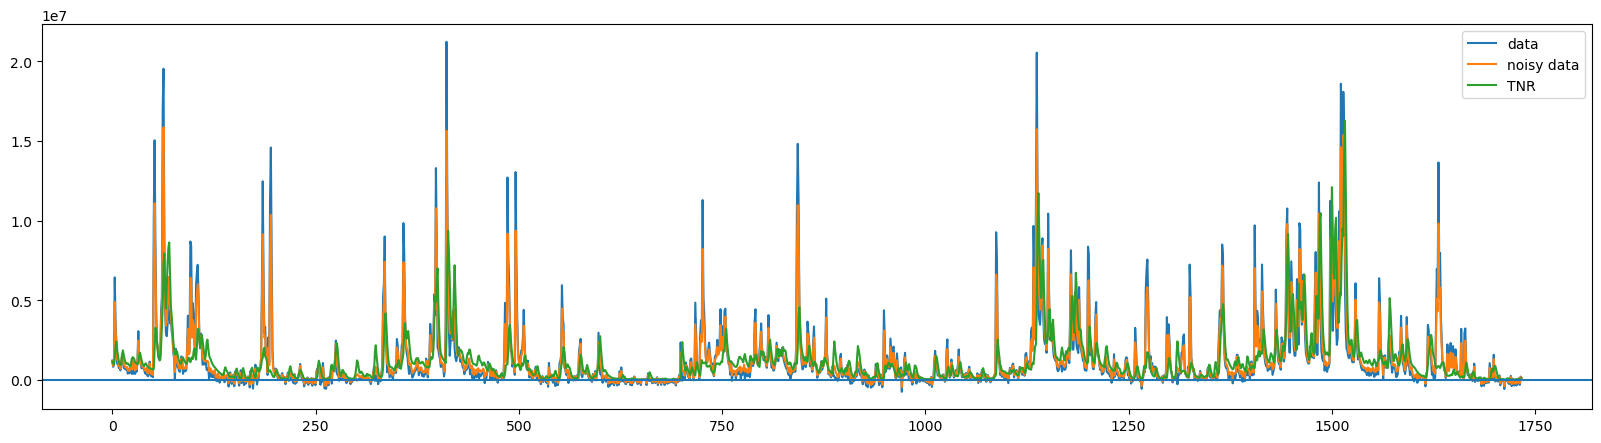

In [17]:
import matplotlib.pyplot as plt
# plt.plot(flow_scaling_factor(forcings['theoretical_natural_runoff'].sel(node=1).values))
plt.figure(figsize=(20, 5))

data = forcings['obs_inflow'].sel(node=1).fillna(0)
tnr = forcings['theoretical_natural_runoff'].sel(node=1).values

tnr_minus_data = tnr - data

noisy_data = data + tnr_minus_data * 0.3
# noisy_data, noise = add_scaled_gaussian_noise(data, noise_std_base, flow_scaling_factor)

# plt.plot(noise, label='noise')
plt.plot(data, label='data')
plt.plot(noisy_data, label='noisy data')
# plt.axhline(data.mean())
# plt.axhline(data.mean() + data.std(), linestyle='--')
plt.plot(tnr, label='TNR')
plt.legend()
plt.axhline(0)

In [176]:
forcings['obs_inflow'].sel(node=1).max()

<xarray.DataArray 'obs_inflow' ()> Size: 8B
array(21238675.2)
Coordinates:
    node     int64 8B 1

In [55]:
## USING GAUSSIAN NOISE

orig_obs_inflow_1 = forcings['obs_inflow'].sel(node=1).fillna(0)
orig_obs_inflow_3 = forcings['obs_inflow'].sel(node=3).fillna(0)

noise_std_dev_1 = 5e6         # m3
noise_std_dev_3 = 7e6

noisy_obs_inflows_1 = []
noisy_obs_inflows_3 = []
rmses_1 = []
rmses_3 = []

for noise_std_dev_1 in np.linspace(0, 150e6, 10):
    noisy_obs_inflow_1 = add_scaled_gaussian_noise(orig_obs_inflow_1.fillna(0), noise_std_dev_1, flow_scaling_factor)
    noisy_inflow_stats_1 = get_stats(orig_obs_inflow_1.fillna(0).values, noisy_obs_inflow_1.fillna(0).values)
    noisy_inflow_nrmse_1 = noisy_inflow_stats_1['norm_rmse']
    rmses_1.append(noisy_inflow_nrmse_1)
    noisy_obs_inflows_1.append(noisy_obs_inflow_1)
    print(f'1: {noise_std_dev_1:.2f}, {noisy_inflow_nrmse_1:.2f}')


for noise_std_dev_3 in np.linspace(0, 600e6, 10):
    noisy_obs_inflow_3 = add_scaled_gaussian_noise(orig_obs_inflow_3.fillna(0), noise_std_dev_3, flow_scaling_factor)
    noisy_inflow_stats_3 = get_stats(orig_obs_inflow_3.fillna(0).values, noisy_obs_inflow_3.fillna(0).values)
    noisy_inflow_nrmse_3 = noisy_inflow_stats_3['norm_rmse']
    rmses_3.append(noisy_inflow_nrmse_3)
    noisy_obs_inflows_3.append(noisy_obs_inflow_1)
    print(f'3: {noise_std_dev_3:.2f}, {noisy_inflow_nrmse_3:.2f}')


# ### USING ORIG - TNR

# orig_obs_inflow_1 = forcings['obs_inflow'].sel(node=1).fillna(0)
# orig_obs_inflow_3 = forcings['obs_inflow'].sel(node=3).fillna(0)

# noisy_obs_inflows_1 = []
# noisy_obs_inflows_3 = []
# rmses_1 = []
# rmses_3 = []

# diff_1 = forcings['theoretical_natural_runoff'].sel(node=1).values - orig_obs_inflow_1.fillna(0).values
# diff_3 = forcings['theoretical_natural_runoff'].sel(node=3).values - orig_obs_inflow_3.fillna(0).values

# for scaling_factor in np.linspace(0, 1, 10):
#     noisy_obs_inflow_1 = orig_obs_inflow_1 + diff_1 * scaling_factor
#     noisy_inflow_stats_1 = get_stats(orig_obs_inflow_1.fillna(0).values, noisy_obs_inflow_1.fillna(0).values)
#     noisy_inflow_nrmse_1 = noisy_inflow_stats_1['norm_rmse']
#     rmses_1.append(noisy_inflow_nrmse_1)
#     noisy_obs_inflows_1.append(noisy_obs_inflow_1)
#     print(f'1: {scaling_factor:.2f}, {noisy_inflow_nrmse_1:.2f}')
#     noisy_obs_inflow_3 = orig_obs_inflow_3 + diff_3 * scaling_factor
#     noisy_inflow_stats_3 = get_stats(orig_obs_inflow_3.fillna(0).values, noisy_obs_inflow_3.fillna(0).values)
#     noisy_inflow_nrmse_3 = noisy_inflow_stats_3['norm_rmse']
#     rmses_3.append(noisy_inflow_nrmse_3)
#     noisy_obs_inflows_3.append(noisy_obs_inflow_3)
#     print(f'3: {scaling_factor:.2f}, {noisy_inflow_nrmse_3:.2f}')



1: 0.00, 0.00
1: 16666666.67, 0.14
1: 33333333.33, 0.23
1: 50000000.00, 0.34
1: 66666666.67, 0.54
1: 83333333.33, 0.53
1: 100000000.00, 0.72
1: 116666666.67, 0.81
1: 133333333.33, 0.95
1: 150000000.00, 1.10
3: 0.00, 0.00
3: 66666666.67, 0.12
3: 133333333.33, 0.22
3: 200000000.00, 0.32
3: 266666666.67, 0.45
3: 333333333.33, 0.56
3: 400000000.00, 0.63
3: 466666666.67, 0.77
3: 533333333.33, 0.85
3: 600000000.00, 0.96


In [56]:
noisy_obs_inflows_1[-1].hvplot() * orig_obs_inflow_1.hvplot() * forcings['theoretical_natural_runoff'].sel(node=1).hvplot()

:Overlay
   .Curve.I   :Curve   [time]   (obs_inflow)
   .Curve.II  :Curve   [time]   (obs_inflow)
   .Curve.III :Curve   [time]   (theoretical_natural_runoff)

## run for noisy forcings [-1]

In [ ]:
noisy_forcings = forcings.copy(deep=True)
# noisy_forcings['obs_inflow'].loc[dict(node=[1, 3])] = xr.concat([noisy_obs_inflow_1, noisy_obs_inflow_3], dim='node')
noisy_forcings['obs_inflow'].loc[dict(node=[1])] = noisy_obs_inflows_1[-1]
noisy_forcings['obs_inflow'].loc[dict(node=[3])] = noisy_obs_inflows_3[-1]
noisy_forcings

<xarray.Dataset> Size: 472kB
Dimensions:                     (time: 1734, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
noisy_forcings.sel(node=1)

<xarray.Dataset> Size: 83kB
Dimensions:                     (time: 1734)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
    node                        int64 8B 1
Data variables:
    theoretical_natural_runoff  (time) float64 14kB 1.137e+06 ... 8.966e+04
    storage_change              (time) float64 14kB -8.02e+05 ... 1.47e+05
    obs_inflow                  (time) float64 14kB 0.0 0.0 ... 1.705e+07 0.0
    obs_outflow                 (time) float64 14kB 1.713e+06 0.0 ... 0.0
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
forcings.sel(node=1)

<xarray.Dataset> Size: 83kB
Dimensions:                     (time: 1734)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
    node                        int64 8B 1
Data variables:
    theoretical_natural_runoff  (time) float64 14kB 1.137e+06 ... 8.966e+04
    storage_change              (time) float64 14kB -8.02e+05 ... 1.47e+05
    obs_inflow                  (time) float64 14kB 1.201e+06 ... 1.297e+05
    obs_outflow                 (time) float64 14kB 1.713e+06 0.0 ... 0.0
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
(noisy_forcings.sel(node=1) - forcings.sel(node=1))['obs_inflow'].rename('noisy - obs (m3)').hvplot(x='time')

:Curve   [time]   (noisy - obs (m3))

In [ ]:
noisy_forcings.sel(node=1)['obs_inflow'].hvplot().opts(title='Laurel Dam')# * noisy_obs_inflow_1.hvplot()

:Curve   [time]   (obs_inflow)

### run resorr

In [ ]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(noisy_forcings.time.values):
    dt = aggregated_subset['dt'].sel(time=timestep).values.item()
    reservoir_network.update(noisy_forcings, dt, 'wb_obs_inflow_upstream')

reservoir_network.data

  0%|          | 0/1734 [00:00<?, ?it/s]

KeyboardInterrupt: 

`reservoir_network.data` contains the model results. Plotting and analysis below.

In [ ]:
ds = reservoir_network.data

In [ ]:
noisy_forcings.sel(node=1)['obs_inflow'].hvplot(label='noisy') * ds.sel(node=1)['obs_inflow'].hvplot()

:Overlay
   .Curve.Noisy :Curve   [time]   (obs_inflow)
   .Curve.I     :Curve   [time]   (obs_inflow)

In [ ]:
NODE = 2
ds.sel(node=NODE).hvplot('time', 'obs_inflow', label='observed inflow') \
* ds.sel(node=NODE).hvplot('time', 'inflow', label='modeled inflow') \
* ds.sel(node=NODE).hvplot('time', 'outflow', label='outflow') \
* ds.sel(node=NODE).hvplot('time', 'theoretical_natural_runoff', label='tnr')

:Overlay
   .Curve.Observed_inflow :Curve   [time]   (obs_inflow)
   .Curve.Modeled_inflow  :Curve   [time]   (inflow)
   .Curve.Outflow         :Curve   [time]   (outflow)
   .Curve.Tnr             :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
# reservoir_network.data.to_netcdf(f'/water2/pdas47/2023_01_24-river-regulation/regulation-experiments/regulation-results/insitu.2015-2019.regulated.{run_type}.nc')

In [ ]:
node = 0

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II  :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)
   .Overlay.III :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [ ]:
node = 2

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.6552553661949508,
 'pearson-r p-val': 3.9604655836119955e-213,
 'nse': 0.42613395291248335,
 'nse1': 0.3648895537856768,
 'rmse': 32295890.6270654,
 'norm_rmse': 0.08023332590786343,
 'mae': 16812728.549744703,
 'norm_mae': 0.041768197220783065,
 'kge': 0.5489970902024591}

In [ ]:
rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.631364696651363,
 'pearson-r p-val': 2.160983410173374e-193,
 'nse': 0.39365381627417095,
 'nse1': 0.3781587898672444,
 'rmse': 33197266.48566465,
 'norm_rmse': 0.08247263195034384,
 'mae': 16461463.560117071,
 'norm_mae': 0.040895542593658546,
 'kge': 0.49402349938157075}

### Save stats

- Focus on one dam, Cordell Hull dam.
- Although save stats for all dams.

In [ ]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.114e+08 ... 1.42...
    outflow                     (node, time) float64 111kB 1.114e+08 ... 1.84...
    regulated_runoff            (node, time) float64 111kB 8.996e+07 ... 1.43...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -1.954e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']


dfs = []
for node, name in zip(nodes_with_upstream, names):
    print(name)
    rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

df = pd.concat(dfs)
df

Wolf Creek Dam
Old Hickory Dam
Cordell Hull Dam
Barkley Dam


,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
2,0.655255,3.960466e-213,0.426134,0.364890,3.229589e+07,0.080233,1.681273e+07,0.041768,0.548997,Wolf Creek Dam,model
2,0.631365,2.160983e-193,0.393654,0.378159,3.319727e+07,0.082473,1.646146e+07,0.040896,0.494023,Wolf Creek Dam,tnr
4,0.792941,0.000000e+00,0.417166,0.356620,3.370259e+07,0.121989,2.186026e+07,0.079125,0.670142,Old Hickory Dam,model
4,0.796772,0.000000e+00,0.379965,0.310337,3.476153e+07,0.125821,2.343283e+07,0.084817,0.636085,Old Hickory Dam,tnr
7,0.804505,0.000000e+00,-0.689746,-0.099534,3.596092e+07,0.184088,2.378052e+07,0.121735,0.084901,Cordell Hull Dam,model
7,0.747232,1.657698e-309,-0.892977,-0.101874,3.806211e+07,0.194844,2.383114e+07,0.121994,0.030968,Cordell Hull Dam,tnr
0,0.784517,0.000000e+00,0.467504,0.326400,5.173161e+07,0.090536,3.463025e+07,0.060607,0.725712,Barkley Dam,model
0,0.838198,0.000000e+00,0.578872,0.356372,4.600496e+07,0.080514,3.308937e+07,0.057910,0.745146,Barkley Dam,tnr


## run for noisy forcings [0]

In [ ]:
noisy_forcings = forcings.copy(deep=True)
# noisy_forcings['obs_inflow'].loc[dict(node=[1, 3])] = xr.concat([noisy_obs_inflow_1, noisy_obs_inflow_3], dim='node')
noisy_forcings['obs_inflow'].loc[dict(node=[1])] = noisy_obs_inflows_1[0]
noisy_forcings['obs_inflow'].loc[dict(node=[3])] = noisy_obs_inflows_3[0]
noisy_forcings

<xarray.Dataset> Size: 472kB
Dimensions:                     (time: 1734, node: 8)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
Data variables:
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
noisy_forcings.sel(node=1)

<xarray.Dataset> Size: 83kB
Dimensions:                     (time: 1734)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
    node                        int64 8B 1
Data variables:
    theoretical_natural_runoff  (time) float64 14kB 1.137e+06 ... 8.966e+04
    storage_change              (time) float64 14kB -8.02e+05 ... 1.47e+05
    obs_inflow                  (time) float64 14kB 1.122e+06 ... 1.368e+05
    obs_outflow                 (time) float64 14kB 1.713e+06 0.0 ... 0.0
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
forcings.sel(node=1)

<xarray.Dataset> Size: 83kB
Dimensions:                     (time: 1734)
Coordinates:
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
    node                        int64 8B 1
Data variables:
    theoretical_natural_runoff  (time) float64 14kB 1.137e+06 ... 8.966e+04
    storage_change              (time) float64 14kB -8.02e+05 ... 1.47e+05
    obs_inflow                  (time) float64 14kB 1.201e+06 ... 1.297e+05
    obs_outflow                 (time) float64 14kB 1.713e+06 0.0 ... 0.0
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
(noisy_forcings.sel(node=1) - forcings.sel(node=1))['obs_inflow'].rename('noisy - obs (m3)').hvplot(x='time')

:Curve   [time]   (noisy - obs (m3))

In [ ]:
noisy_forcings.sel(node=1)['obs_inflow'].hvplot().opts(title='Laurel Dam')# * noisy_obs_inflow_1.hvplot()

:Curve   [time]   (obs_inflow)

### run resorr

In [ ]:
reservoir_network = ReservoirNetwork(G, start_time)

for timestep in tqdm(noisy_forcings.time.values):
    dt = aggregated_subset['dt'].sel(time=timestep).values.item()
    reservoir_network.update(noisy_forcings, dt, 'wb_obs_inflow_upstream')

reservoir_network.data

  0%|          | 0/1734 [00:00<?, ?it/s]

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.117e+08 ... 1.42...
    outflow                     (node, time) float64 111kB 1.117e+08 ... 1.84...
    regulated_runoff            (node, time) float64 111kB 9.026e+07 ... 1.43...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -1.984e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

`reservoir_network.data` contains the model results. Plotting and analysis below.

In [ ]:
ds = reservoir_network.data

In [ ]:
noisy_forcings.sel(node=1)['obs_inflow'].hvplot(label='noisy') * ds.sel(node=1)['obs_inflow'].hvplot()

:Overlay
   .Curve.Noisy :Curve   [time]   (obs_inflow)
   .Curve.I     :Curve   [time]   (obs_inflow)

In [ ]:
NODE = 2
ds.sel(node=NODE).hvplot('time', 'obs_inflow', label='observed inflow') \
* ds.sel(node=NODE).hvplot('time', 'inflow', label='modeled inflow') \
* ds.sel(node=NODE).hvplot('time', 'outflow', label='outflow') \
* ds.sel(node=NODE).hvplot('time', 'theoretical_natural_runoff', label='tnr')

:Overlay
   .Curve.Observed_inflow :Curve   [time]   (obs_inflow)
   .Curve.Modeled_inflow  :Curve   [time]   (inflow)
   .Curve.Outflow         :Curve   [time]   (outflow)
   .Curve.Tnr             :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
# reservoir_network.data.to_netcdf(f'/water2/pdas47/2023_01_24-river-regulation/regulation-experiments/regulation-results/insitu.2015-2019.regulated.{run_type}.nc')

In [ ]:
node = 0

ds = reservoir_network.data
ds['obs_inflow'] = subset['obs_inflow']

ds['inflow'].sel(node=node).hvplot(label='inflow') * ds['obs_inflow'].sel(node=node).hvplot(label='observed') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR')

:Overlay
   .Curve.Inflow   :Curve   [time]   (inflow)
   .Curve.Observed :Curve   [time]   (obs_inflow)
   .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)

In [ ]:
from bokeh.models.formatters import NumeralTickFormatter

# plot comparing downstream and upstream nodes
# node = 0
current_node_plot = ds['inflow'].sel(node=node).hvplot(label='inflow').opts(color='#069af3') * ds['obs_inflow'].sel(node=node).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=node).hvplot(label='TNR').opts(color='green', line_dash='3 3')
current_node_plot = current_node_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'))

upstreams = list(reservoir_network.predecessors(node))

plots = [current_node_plot]
for upstream in upstreams:
    upstream_plot = ds['inflow'].sel(node=upstream).hvplot(label='inflow').opts(color='#a2cffe') * ds['obs_inflow'].sel(node=upstream).hvplot(label='observed').opts(color='k') * ds['theoretical_natural_runoff'].sel(node=upstream).hvplot(label='TNR').opts(color='green', line_dash='dashed')
    upstream_plot *= ds['storage_change'].sel(node=upstream).hvplot(label='storage change').opts(color='gray')
    upstream_plot *= ds['outflow'].sel(node=upstream).hvplot(label='outflow').opts(color='red')
    upstream_plot = upstream_plot.opts(yformatter=NumeralTickFormatter(format='0.0a'), ylabel='inflow [m3]')
    plots.append(upstream_plot)

import panel as pn

hv.Layout(plots).cols(1)

:Layout
   .Overlay.I   :Overlay
      .Curve.Inflow   :Curve   [time]   (inflow)
      .Curve.Observed :Curve   [time]   (obs_inflow)
      .Curve.TNR      :Curve   [time]   (theoretical_natural_runoff)
   .Overlay.II  :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)
   .Overlay.III :Overlay
      .Curve.Inflow         :Curve   [time]   (inflow)
      .Curve.Observed       :Curve   [time]   (obs_inflow)
      .Curve.TNR            :Curve   [time]   (theoretical_natural_runoff)
      .Curve.Storage_change :Curve   [time]   (storage_change)
      .Curve.Outflow        :Curve   [time]   (outflow)

In [ ]:
node = 2

rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')

print('river regulation model results')
get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)

river regulation model results


{'pearson-r': 0.6372398778132224,
 'pearson-r p-val': 4.395207566090261e-198,
 'nse': 0.40246353862539863,
 'nse1': 0.38375329163207705,
 'rmse': 32955219.290662564,
 'norm_rmse': 0.08187130927106118,
 'mae': 16313365.162265401,
 'norm_mae': 0.04052761878692793,
 'kge': 0.4927684459101591}

In [ ]:
rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')

print('TNR vs. Obs results')
get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)

TNR vs. Obs results


{'pearson-r': 0.631364696651363,
 'pearson-r p-val': 2.160983410173374e-193,
 'nse': 0.39365381627417095,
 'nse1': 0.3781587898672444,
 'rmse': 33197266.48566465,
 'norm_rmse': 0.08247263195034384,
 'mae': 16461463.560117071,
 'norm_mae': 0.040895542593658546,
 'kge': 0.49402349938157075}

### Save stats

- Focus on one dam, Cordell Hull dam.
- Although save stats for all dams.

In [ ]:
ds

<xarray.Dataset> Size: 1MB
Dimensions:                     (node: 8, time: 1734)
Coordinates:
  * node                        (node) int64 64B 0 1 2 3 4 5 6 7
  * time                        (time) datetime64[ns] 14kB 2015-01-01 ... 201...
Data variables:
    inflow                      (node, time) float64 111kB 1.117e+08 ... 1.42...
    outflow                     (node, time) float64 111kB 1.117e+08 ... 1.84...
    regulated_runoff            (node, time) float64 111kB 9.026e+07 ... 1.43...
    natural_runoff              (node, time) float64 111kB 2.144e+07 ... -2.3...
    theoretical_natural_runoff  (time, node) float64 111kB 9.186e+07 ... 1.11...
    storage                     (node, time) float64 111kB nan nan ... nan nan
    storage_change              (time, node) float64 111kB 0.0 ... -4.159e+06
    regulation                  (node, time) float64 111kB -1.984e+07 ... -1....
    obs_inflow                  (time, node) float64 111kB 1.409e+08 ... 7.09...
    obs_outflow                 (time, node) float64 111kB 1.409e+08 ... 1.12...
    dt                          (time) int64 14kB 1 1 1 1 1 1 1 ... 1 1 1 1 1 1

In [ ]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']


dfs = []
for node, name in zip(nodes_with_upstream, names):
    print(name)
    rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

df = pd.concat(dfs)
df

Wolf Creek Dam
Old Hickory Dam
Cordell Hull Dam
Barkley Dam


,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
2,0.637240,4.395208e-198,0.402464,0.383753,3.295522e+07,0.081871,1.631337e+07,0.040528,0.492768,Wolf Creek Dam,model
2,0.631365,2.160983e-193,0.393654,0.378159,3.319727e+07,0.082473,1.646146e+07,0.040896,0.494023,Wolf Creek Dam,tnr
4,0.800395,0.000000e+00,0.480439,0.401897,3.182065e+07,0.115177,2.032186e+07,0.073556,0.715255,Old Hickory Dam,model
4,0.796772,0.000000e+00,0.379965,0.310337,3.476153e+07,0.125821,2.343283e+07,0.084817,0.636085,Old Hickory Dam,tnr
7,0.817204,0.000000e+00,-0.413636,0.002759,3.289190e+07,0.168377,2.156815e+07,0.110410,0.177038,Cordell Hull Dam,model
7,0.747232,1.657698e-309,-0.892977,-0.101874,3.806211e+07,0.194844,2.383114e+07,0.121994,0.030968,Cordell Hull Dam,tnr
0,0.786846,0.000000e+00,0.489281,0.341201,5.066272e+07,0.088665,3.386931e+07,0.059275,0.740954,Barkley Dam,model
0,0.838198,0.000000e+00,0.578872,0.356372,4.600496e+07,0.080514,3.308937e+07,0.057910,0.745146,Barkley Dam,tnr


## all in one, in a loop

In [20]:
from dask.distributed import Client, LocalCluster

client = Client(n_workers=10, threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 10
Total threads: 10,Total memory: 187.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38327,Workers: 10
Dashboard: http://127.0.0.1:8787/status,Total threads: 10
Started: Just now,Total memory: 187.55 GiB
Comm: tcp://127.0.0.1:44619,Total threads: 1
Dashboard: http://127.0.0.1:45015/status,Memory: 18.76 GiB
Nanny: tcp://127.0.0.1:44715,


In [197]:
import dask
np.random.seed(0)

# Load the data
run_type = 'E4'
ds = xr.open_dataset(f'/tiger1/pdas47/ResORR-revision/data-cumberland/regulation-data/insitu.2015-2019.regulated.{run_type}.nc')

start_time = pd.to_datetime('2015-01-01')
end_time = pd.to_datetime('2019-09-30')

subset = ds.sel(time=slice(start_time, end_time))
aggregated_subset = calculate_volumes(aggregate(subset, 'daily'))

if start_time < aggregated_subset.time.min():
    start_time = aggregated_subset.time.min().values
if end_time > aggregated_subset.time.max():
    end_time = aggregated_subset.time.max().values

forcings = xr.Dataset(
    data_vars={
        'theoretical_natural_runoff': aggregated_subset['unregulated_inflow'],
        'storage_change': aggregated_subset['obs_storage_change'],
        'obs_inflow': aggregated_subset['obs_inflow'],
        'obs_outflow': aggregated_subset['obs_outflow'],
        'dt': aggregated_subset['dt']
    }
).sel(time=slice(start_time, end_time))

orig_obs_inflow_1 = forcings['obs_inflow'].sel(node=1).fillna(0)
orig_obs_inflow_3 = forcings['obs_inflow'].sel(node=3).fillna(0)

## USING GAUSSIAN NOISE
noise_std_devs_1 = []
noise_std_devs_3 = []
noisy_obs_inflows_1 = []
noisy_obs_inflows_3 = []
rmses_1 = []
rmses_3 = []

for noise_std_dev_1 in np.linspace(0, 100e6, 10):
    noisy_obs_inflow_1 = add_scaled_gaussian_noise(orig_obs_inflow_1.fillna(0), noise_std_dev_1, flow_scaling_factor)
    noisy_inflow_stats_1 = get_stats(orig_obs_inflow_1.values, noisy_obs_inflow_1.values)
    noisy_inflow_nrmse_1 = noisy_inflow_stats_1['norm_rmse']
    rmses_1.append(noisy_inflow_nrmse_1)
    noisy_obs_inflows_1.append(noisy_obs_inflow_1)
    noise_std_devs_1.append(noise_std_dev_1)
    print(f'1: {noise_std_dev_1:.2f}, {noisy_inflow_nrmse_1:.2f}')

for noise_std_dev_3 in np.linspace(0, 400e6, 10):
    noisy_obs_inflow_3 = add_scaled_gaussian_noise(orig_obs_inflow_3.fillna(0), noise_std_dev_3, flow_scaling_factor)
    noisy_inflow_stats_3 = get_stats(orig_obs_inflow_3.values, noisy_obs_inflow_3.values)
    noisy_inflow_nrmse_3 = noisy_inflow_stats_3['norm_rmse']
    rmses_3.append(noisy_inflow_nrmse_3)
    noisy_obs_inflows_3.append(noisy_obs_inflow_1)
    noise_std_devs_3.append(noise_std_dev_3)
    print(f'3: {noise_std_dev_3:.2f}, {noisy_inflow_nrmse_3:.2f}')

# ### TNR - OBS
# orig_obs_inflow_1 = forcings['obs_inflow'].sel(node=1).fillna(0)
# orig_obs_inflow_3 = forcings['obs_inflow'].sel(node=3).fillna(0)

# noisy_obs_inflows_1 = []
# noisy_obs_inflows_3 = []
# rmses_1 = []
# rmses_3 = []

# diff_1 = forcings['theoretical_natural_runoff'].sel(node=1).values - orig_obs_inflow_1.fillna(0).values
# diff_3 = forcings['theoretical_natural_runoff'].sel(node=3).values - orig_obs_inflow_3.fillna(0).values

# for scaling_factor in np.linspace(0, 1.2, 15):
#     noisy_obs_inflow_1 = orig_obs_inflow_1 + diff_1 * scaling_factor
#     noisy_inflow_stats_1 = get_stats(orig_obs_inflow_1.fillna(0).values, noisy_obs_inflow_1.fillna(0).values)
#     noisy_inflow_nrmse_1 = noisy_inflow_stats_1['norm_rmse']
#     rmses_1.append(noisy_inflow_nrmse_1)
#     noisy_obs_inflows_1.append(noisy_obs_inflow_1)
#     print(f'1: {scaling_factor:.2f}, {noisy_inflow_nrmse_1:.2f}')
#     noisy_obs_inflow_3 = orig_obs_inflow_3 + diff_3 * scaling_factor
#     noisy_inflow_stats_3 = get_stats(orig_obs_inflow_3.fillna(0).values, noisy_obs_inflow_3.fillna(0).values)
#     noisy_inflow_nrmse_3 = noisy_inflow_stats_3['norm_rmse']
#     rmses_3.append(noisy_inflow_nrmse_3)
#     noisy_obs_inflows_3.append(noisy_obs_inflow_3)
#     print(f'3: {scaling_factor:.2f}, {noisy_inflow_nrmse_3:.2f}')

case_dfs = []

def run_for_case(i):
    noisy_forcings = forcings.copy(deep=True)
    noisy_forcings['obs_inflow'].loc[dict(node=[1])] = noisy_obs_inflows_1[i]
    noisy_forcings['obs_inflow'].loc[dict(node=[3])] = noisy_obs_inflows_3[i]
    
    reservoir_network = ReservoirNetwork(G, start_time)

    for timestep in tqdm(noisy_forcings.time.values):
        dt = aggregated_subset['dt'].sel(time=timestep).values.item()
        reservoir_network.update(noisy_forcings, dt, 'wb_obs_inflow_upstream')

    ds = reservoir_network.data

    nodes_with_upstream = [2, 4, 7, 0]
    names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']

    dfs = []
    for node, name in zip(nodes_with_upstream, names):
        rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
        # print('river regulation model results')
        s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
        model_df = pd.DataFrame(s, index=[node])
        model_df['name'] = name
        model_df['model_or_tnr'] = 'model'

        rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
        # print('TNR vs. Obs results')
        s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
        tnr_df = pd.DataFrame(s, index=[node])
        tnr_df['name'] = name
        tnr_df['model_or_tnr'] = 'tnr'

        dfs.append(pd.concat([model_df, tnr_df]))

    case_df = pd.concat(dfs)
    print(case_df)
    case_df['rmse_1'] = rmses_1[i]
    case_df['rmse_3'] = rmses_3[i]
    case_df['noise_std_dev_1'] = noise_std_devs_1[i]
    case_df['noise_std_dev_3'] = noise_std_devs_3[i]
    case_dfs.append(case_df)

    return case_df

futures = []
# loop through the noisy datas and run the reservoir model
for i in range(len(rmses_1)):
    future = client.submit(run_for_case, i)
    futures.append(future)

print(futures)
# dask.compute(*case_dfs)
# df

1: 0.00, 0.00
1: 11111111.11, 0.10
1: 22222222.22, 0.17
1: 33333333.33, 0.24
1: 44444444.44, 0.33
1: 55555555.56, 0.43
1: 66666666.67, 0.51
1: 77777777.78, 0.56
1: 88888888.89, 0.59
1: 100000000.00, 0.67
3: 0.00, 0.00
3: 44444444.44, 0.09
3: 88888888.89, 0.15
3: 133333333.33, 0.22
3: 177777777.78, 0.30
3: 222222222.22, 0.39
3: 266666666.67, 0.40
3: 311111111.11, 0.52
3: 355555555.56, 0.58
3: 400000000.00, 0.61
[<Future: pending, key: run_for_case-e5f0f33791ff5ca3422148aa32d4b68d>, <Future: pending, key: run_for_case-417721f7ed4cd8b17aa881953a0f127c>, <Future: pending, key: run_for_case-ceef1ac5690cc3194c03fb6b0e2f1340>, <Future: pending, key: run_for_case-1885d2e45c6812a5f6f3279d032f534e>, <Future: pending, key: run_for_case-2ce75f745ad4410a545a846cf2a17d08>, <Future: pending, key: run_for_case-6b7410590b9070938450efce02131925>, <Future: pending, key: run_for_case-579391b9b9219441e1982e4ed99e5ce2>, <Future: pending, key: run_for_case-73b23de73872eaf4c57bc8645c10f0d8>, <Future: pending,

In [198]:
results = client.gather(futures)
results

   pearson-r  pearson-r p-val  ...              name  model_or_tnr
2   0.637523    2.594850e-198  ...    Wolf Creek Dam         model
2   0.631365    2.160983e-193  ...    Wolf Creek Dam           tnr
4   0.810520     0.000000e+00  ...   Old Hickory Dam         model
4   0.796772     0.000000e+00  ...   Old Hickory Dam           tnr
7   0.825759     0.000000e+00  ...  Cordell Hull Dam         model
7   0.747232    1.657698e-309  ...  Cordell Hull Dam           tnr
0   0.794503     0.000000e+00  ...       Barkley Dam         model
0   0.838198     0.000000e+00  ...       Barkley Dam           tnr

[8 rows x 11 columns]
  0%|          | 0/1734 [00:00<?, ?it/s]
   pearson-r  pearson-r p-val  ...              name  model_or_tnr
2   0.645745    4.644298e-205  ...    Wolf Creek Dam         model
2   0.631365    2.160983e-193  ...    Wolf Creek Dam           tnr
4   0.811616     0.000000e+00  ...   Old Hickory Dam         model
4   0.796772     0.000000e+00  ...   Old Hickory Dam           tn

[   pearson-r  pearson-r p-val  ...  noise_std_dev_1  noise_std_dev_3
 2   0.637523    2.594850e-198  ...              0.0              0.0
 2   0.631365    2.160983e-193  ...              0.0              0.0
 4   0.810520     0.000000e+00  ...              0.0              0.0
 4   0.796772     0.000000e+00  ...              0.0              0.0
 7   0.825759     0.000000e+00  ...              0.0              0.0
 7   0.747232    1.657698e-309  ...              0.0              0.0
 0   0.794503     0.000000e+00  ...              0.0              0.0
 0   0.838198     0.000000e+00  ...              0.0              0.0
 
 [8 rows x 15 columns],
    pearson-r  pearson-r p-val  ...  noise_std_dev_1  noise_std_dev_3
 2   0.645745    4.644298e-205  ...     1.111111e+07     4.444444e+07
 2   0.631365    2.160983e-193  ...     1.111111e+07     4.444444e+07
 4   0.811616     0.000000e+00  ...     1.111111e+07     4.444444e+07
 4   0.796772     0.000000e+00  ...     1.111111e+07     4.44444

In [200]:
df = pd.concat(results)
df.index.name = 'node'
df.reset_index(inplace=True)
df.loc[(df['node'] == 4)&(df['model_or_tnr'] == 'model')]

,node,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr,rmse_1,rmse_3,noise_std_dev_1,noise_std_dev_3
2,4,0.810520,0.0,0.471867,0.390790,3.208205e+07,0.116123,2.069925e+07,0.074922,0.691390,Old Hickory Dam,model,0.004032,0.004823,0.000000e+00,0.000000e+00
10,4,0.811616,0.0,0.470721,0.389516,3.211687e+07,0.116249,2.074252e+07,0.075079,0.688425,Old Hickory Dam,model,0.097209,0.090636,1.111111e+07,4.444444e+07
18,4,0.810078,0.0,0.462809,0.386646,3.235602e+07,0.117115,2.084006e+07,0.075432,0.683593,Old Hickory Dam,model,0.170671,0.154191,2.222222e+07,8.888889e+07
26,4,0.813529,0.0,0.463715,0.383177,3.232873e+07,0.117016,2.095793e+07,0.075858,0.678637,Old Hickory Dam,model,0.241214,0.221847,3.333333e+07,1.333333e+08
34,4,0.813697,0.0,0.447151,0.374528,3.282418e+07,0.118809,2.125178e+07,0.076922,0.663650,Old Hickory Dam,model,0.334581,0.297856,4.444444e+07,1.777778e+08
42,4,0.809116,0.0,0.426920,0.363054,3.341937e+07,0.120963,2.164165e+07,0.078333,0.653344,Old Hickory Dam,model,0.434153,0.392113,5.555556e+07,2.222222e+08
50,4,0.810961,0.0,0.433296,0.368189,3.323295e+07,0.120289,2.146718e+07,0.077702,0.655409,Old Hickory Dam,model,0.512913,0.403053,6.666667e+07,2.666667e+08
58,4,0.809862,0.0,0.410596,0.345957,3.389200e+07,0.122674,2.222255e+07,0.080436,0.638100,Old Hickory Dam,model,0.555570,0.518019,7.777778e+07,3.111111e+08
66,4,0.812878,0.0,0.404984,0.343287,3.405298e+07,0.123257,2.231327e+07,0.080764,0.628855,Old Hickory Dam,model,0.588418,0.579032,8.888889e+07,3.555556e+08
74,4,0.794094,0.0,0.324443,0.309686,3.628455e+07,0.131334,2.345494e+07,0.084897,0.594556,Old Hickory Dam,model,0.671256,0.610811,1.000000e+08,4.000000e+08


In [201]:
get_stats(
    forcings.sel(node=3)['theoretical_natural_runoff'].fillna(0).values, 
    forcings.sel(node=3)['obs_inflow'].fillna(0).values
)

{'pearson-r': 0.4771967701853779,
 'pearson-r p-val': 2.6158092175298057e-99,
 'nse': -1.2822233503399785,
 'nse1': -0.024177847296162458,
 'rmse': 7546274.174988526,
 'norm_rmse': 0.1640401102545274,
 'mae': 3785779.8198802434,
 'norm_mae': 0.08229488150733195,
 'kge': 0.12099796227428483}

In [202]:
import altair as alt
from altair import datum

NODE = 4
name = df[df.node == NODE].name.values[0]

df_clean = df.copy()
df_clean.loc[df_clean['model_or_tnr']=='model', 'model_or_tnr'] = 'ResORR - with reservoirs'
df_clean.loc[df_clean['model_or_tnr']=='tnr', 'model_or_tnr'] = 'TNR - without reservoirs'

pts = alt.Chart(
    df_clean
).transform_filter(
    datum.node == NODE
).mark_point(
    filled=True,
    size=100,
    opacity=1
).encode(
    x=alt.X('rmse_3:Q').title('Norm. RMSE added to Laurel Dam'),
    y=alt.Y('nse:Q').title('NSE'), #.scale(alt.Scale(domain=[0.0, 0.15])),
    shape=alt.Shape('model_or_tnr').legend(alt.Legend(title="With or without reservoirs")),
    color=alt.Color('model_or_tnr').legend(alt.Legend(title="With or without reservoirs")).scale(alt.Scale(range=['darkblue', 'orange'])),
    tooltip=alt.Tooltip(['pearson-r', 'nse', 'norm_rmse', 'norm_mae', 'kge', 'rmse_1'], format='.2f')
)

line = alt.Chart(
    df
).transform_filter(
    datum.node == NODE
).mark_line(
    color='gray',
).encode(
    x='rmse_3:Q',
    y='nse:Q',
    color=alt.Color('model_or_tnr').legend(None).scale(alt.Scale(range=['darkblue', 'orange'])),
    detail = alt.Detail('model_or_tnr'),
)

chart = alt.layer(line, pts).properties(
    width=300,
    height=300,
    title={
        "text": f'{name}',
        "subtitle": ["Model performance with added noise (higher RMSE) to", "Laurel Dam's observed inflow compared to TNR"]
    },

)
chart.configure_title(
    fontSize=16
).configure_axis(
    titleFontSize=14,
    labelFontSize=12
).configure_legend(
    titleFontSize=14,
    labelFontSize=12,
    symbolSize=200
)

alt.LayerChart(...)

In [167]:
# how does the noise look like?

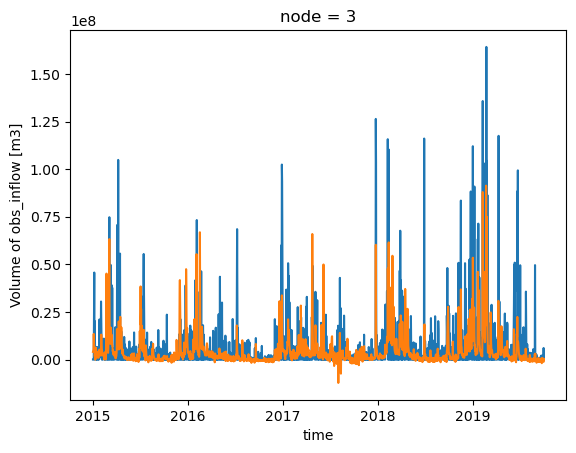

In [175]:
noisy_obs_inflows_3[-1].plot()
forcings['obs_inflow'].sel(node=3).plot()

In [ ]:
client.close()

In [ ]:
nodes_with_upstream = [2, 4, 7, 0]
names = ['Wolf Creek Dam', 'Old Hickory Dam', 'Cordell Hull Dam', 'Barkley Dam']


dfs = []
for node, name in zip(nodes_with_upstream, names):
    print(name)
    rr_res = ds[['obs_inflow', 'inflow']].sel(node=node).dropna(dim='time')
    # print('river regulation model results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['inflow'].data)
    model_df = pd.DataFrame(s, index=[node])
    model_df['name'] = name
    model_df['model_or_tnr'] = 'model'

    rr_res = ds[['obs_inflow', 'theoretical_natural_runoff']].sel(node=node).dropna(dim='time')
    # print('TNR vs. Obs results')
    s = get_stats(rr_res['obs_inflow'].data, rr_res['theoretical_natural_runoff'].data)
    tnr_df = pd.DataFrame(s, index=[node])
    tnr_df['name'] = name
    tnr_df['model_or_tnr'] = 'tnr'

    dfs.append(pd.concat([model_df, tnr_df]))

df = pd.concat(dfs)
df

Wolf Creek Dam
Old Hickory Dam
Cordell Hull Dam
Barkley Dam


,pearson-r,pearson-r p-val,nse,nse1,rmse,norm_rmse,mae,norm_mae,kge,name,model_or_tnr
2,0.661671,9.699726e-219,0.436641,0.380153,3.199888e+07,0.079495,1.640867e+07,0.040764,0.538793,Wolf Creek Dam,model
2,0.631365,2.160983e-193,0.393654,0.378159,3.319727e+07,0.082473,1.646146e+07,0.040896,0.494023,Wolf Creek Dam,tnr
4,0.807706,0.000000e+00,0.481226,0.405365,3.179652e+07,0.115089,2.020404e+07,0.073130,0.705388,Old Hickory Dam,model
4,0.796772,0.000000e+00,0.379965,0.310337,3.476153e+07,0.125821,2.343283e+07,0.084817,0.636085,Old Hickory Dam,tnr
7,0.825163,0.000000e+00,-0.447415,0.009240,3.328255e+07,0.170377,2.142798e+07,0.109692,0.150315,Cordell Hull Dam,model
7,0.747232,1.657698e-309,-0.892977,-0.101874,3.806211e+07,0.194844,2.383114e+07,0.121994,0.030968,Cordell Hull Dam,tnr
0,0.793376,0.000000e+00,0.493336,0.341974,5.046119e+07,0.088312,3.382957e+07,0.059205,0.737245,Barkley Dam,model
0,0.838198,0.000000e+00,0.578872,0.356372,4.600496e+07,0.080514,3.308937e+07,0.057910,0.745146,Barkley Dam,tnr


In [108]:
import altair as alt

In [131]:
NODE = 4
data = df.loc[NODE]
name = df.loc[NODE, 'name'].unique()[0]

bars = alt.Chart(
    data
).mark_bar(
    
).encode(
    x=alt.X('norm_rmse:Q', title='Normalized RMSE'),
    y=alt.Y('model_or_tnr:N', title=None),
    tooltip=alt.Tooltip(['pearson-r', 'nse', 'norm_rmse', 'norm_mae', 'kge'], format='.2f')
).properties(
    width=300,
    height=100,
    title=f'{name}'
)

bars

alt.Chart(...)